In [218]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [571]:
data_dir = '../../../data/checks'

train = pd.read_csv(os.path.join(data_dir, 'train.csv'), sep=',')
train_checks = pd.read_csv(os.path.join(data_dir, 'train_checks.csv'), parse_dates=['datetime'], sep=',')
test = pd.read_csv(os.path.join(data_dir, 'test.csv'), sep=',')
test_checks = pd.read_csv(os.path.join(data_dir, 'test_checks.csv'), parse_dates=['datetime'], sep=',')

catalog1 = pd.read_csv(os.path.join(data_dir, 'catalog1.csv'), sep=',')
catalog2 = pd.read_csv(os.path.join(data_dir, 'catalog2.csv'), sep=',')
catalog3 = pd.read_csv(os.path.join(data_dir, 'catalog3.csv'), sep=',')

In [3]:
train.info(), train_checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13682 entries, 0 to 13681
Data columns (total 5 columns):
check_id    13682 non-null int64
name        13681 non-null object
category    13682 non-null object
price       13682 non-null float64
count       13682 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 534.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042 entries, 0 to 2041
Data columns (total 4 columns):
check_id     2042 non-null int64
shop_name    1967 non-null object
datetime     2042 non-null datetime64[ns]
sum          2042 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 63.9+ KB


(None, None)

In [4]:
test.info(), test_checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
id          3000 non-null int64
check_id    3000 non-null int64
name        3000 non-null object
price       3000 non-null float64
count       3000 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 117.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933 entries, 0 to 932
Data columns (total 4 columns):
check_id     933 non-null int64
shop_name    892 non-null object
datetime     933 non-null datetime64[ns]
sum          933 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 29.2+ KB


(None, None)

In [5]:
catalog1.info(), catalog2.info(), catalog3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49771 entries, 0 to 49770
Data columns (total 3 columns):
category            49771 non-null object
description         49771 non-null object
precise_category    49771 non-null object
dtypes: object(3)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145114 entries, 0 to 145113
Data columns (total 3 columns):
category         145114 non-null object
description      145114 non-null object
main_category    145114 non-null object
dtypes: object(3)
memory usage: 3.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67950 entries, 0 to 67949
Data columns (total 5 columns):
description     55860 non-null object
category_id     67950 non-null object
category_raw    55860 non-null object
PATH            49815 non-null object
category        49815 non-null object
dtypes: object(5)
memory usage: 2.6+ MB


(None, None, None)

In [6]:
train[train.name.isna()]

,check_id,name,category,price,count
3584,997,NaN,Не определена,302.0,1.0


In [7]:
train.head()

,check_id,name,category,price,count
0,0,*3479755 ТRUF.Конф.кр.корп.гл.вк.шок180г,Чай и сладкое,49.0,2.0
1,0,3408392 ECONTA Мешки д/мусора 30л 30шт,Для дома,21.0,1.0
2,0,3260497 ЯШКИНО Рулет С ВАР.СГУЩ. 200г,Чай и сладкое,39.0,1.0
3,0,3300573 Пакет ПЯТЕРОЧКА 65х40см,Упаковка,4.0,1.0
4,0,3413607 ЗЕР/СЕЛ.Сухари с изюмом 250г,Чай и сладкое,35.0,1.0


In [8]:
train.describe(), train.describe(include='object')

(           check_id          price         count
 count  13682.000000   13682.000000  13682.000000
 mean    1875.474784     168.523750      1.442993
 std     1142.304766    1934.014511      2.510821
 min        0.000000       0.000000      0.045000
 25%      924.000000      30.000000      1.000000
 50%     1971.000000      59.000000      1.000000
 75%     2831.000000     120.000000      1.000000
 max     3943.000000  192800.000000     66.070000,
                                    name        category
 count                             13681           13682
 unique                            11312              25
 top     3300573 Пакет ПЯТЕРОЧКА 65х40см  Овощи и фрукты
 freq                                 86            1761)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C1D7BE0>,
      dtype=object)

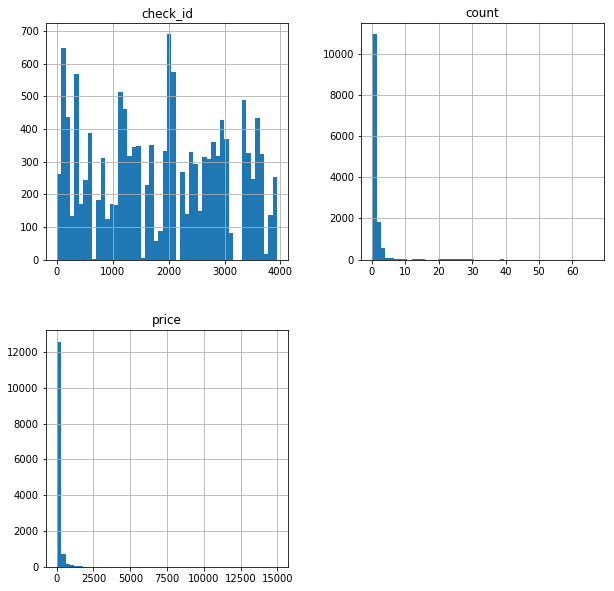

In [9]:
train[train.price < 20000].hist(figsize=(10,10), bins=50)

In [10]:
train.check_id.value_counts().sort_values(ascending=False)[:10]

101     100
100      91
2392     91
1169     90
2080     88
1170     75
2393     65
2250     62
361      55
2623     50
Name: check_id, dtype: int64

In [11]:
train.price.value_counts(bins=6)

(-192.80100000000002, 32133.333]    13679
(160666.667, 192800.0]                  1
(64266.667, 96400.0]                    1
(32133.333, 64266.667]                  1
(128533.333, 160666.667]                0
(96400.0, 128533.333]                   0
Name: price, dtype: int64

In [12]:
train['count'].value_counts()

1.000     9154
2.000     1524
3.000      323
4.000      193
6.000       72
5.000       71
10.000      28
8.000       16
7.000       15
0.950       11
0.500       10
0.180        9
0.388        8
0.730        8
0.710        8
30.000       8
0.700        8
0.220        8
0.284        7
0.400        7
0.340        7
0.234        7
0.750        7
0.356        7
0.482        7
0.410        7
0.328        7
0.436        7
0.294        7
0.230        7
          ... 
24.740       1
1.706        1
1.564        1
1.445        1
0.925        1
2.234        1
1.604        1
0.942        1
50.000       1
12.750       1
9.260        1
1.046        1
2.732        1
2.102        1
0.157        1
2.096        1
0.208        1
12.488       1
0.291        1
0.432        1
0.751        1
1.175        1
2.306        1
0.155        1
1.460        1
2.294        1
0.737        1
1.186        1
0.780        1
1.052        1
Name: count, Length: 1170, dtype: int64

In [13]:
train.category.value_counts()

Овощи и фрукты    1761
Чай и сладкое     1485
Молочка           1415
Для дома          1271
Бакалея           1051
Гастрономия        878
Хлеб               652
Упаковка           628
Мясо и птица       600
Напитки            567
Дети               503
Кафе               422
Здоровье           375
Алкоголь           343
Снеки              332
Кулинария          235
Косметика          230
Животные           191
Одежда и обувь     190
Услуги             140
Машина             118
Табак               99
Рыба                75
Не определена       70
Компьютер           51
Name: category, dtype: int64

In [14]:
train.name.value_counts().sort_values(ascending=False)[:20]

3300573 Пакет ПЯТЕРОЧКА 65х40см                       86
БАНАНЫ свеж. (цена за 1кг)                            41
Пакет ЛЕНТА майка 9кг                                 31
Пакет ЛЕНТА средний майка 12кг                        24
809 Бананы 1кг                                        24
ЯБЛОКИ свеж УРОЖАЙ (цена за кг)                       22
Пакет "Магнит" белый (Пластиктре                      21
Пакет "Магнит" белый (Пластиктрейд)                   18
АПЕЛЬСИНЫ свеж. (цена за 1кг)                         16
Бананы вес 1кг                                        16
3182853 Яйца кур.С0 стол.фас.10шт                     16
807 Яблоко сезонное 1кг                               15
МАНДАРИНЫ свежие (цена за 1кг)                        15
47642 Мандарины                   1кг                 14
БАНАНЫ                                                14
ПАКЕТ-МАЙКА ДИКСИ 38Х65 ПНД 12                        14
Багет с ветчиной и сыром 300г                         13
Пакет с логотипом              

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D623DA0>,
      dtype=object)

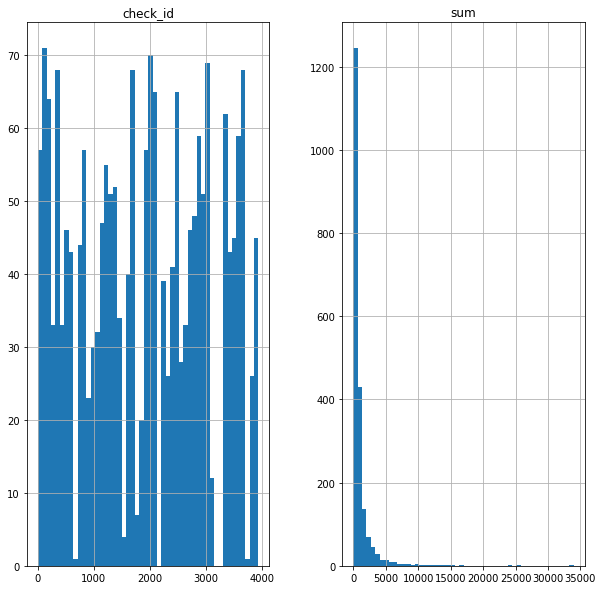

In [15]:
train_checks[train_checks['sum'] < 35000 ].hist(figsize=(10, 10), bins=50)

In [16]:
train_checks.columns

Index(['check_id', 'shop_name', 'datetime', 'sum'], dtype='object')

In [17]:
train_checks.shop_name.value_counts()[:20]

Не известно                                      309
Тандер                                           194
Лента                                            188
Агроторг                                          85
Дикси ЮГ                                          36
АШАН                                              36
О'КЕЙ                                             30
Сити                                              25
Камелот-А                                         22
Гиперглобус                                       19
АГРОТОРГ                                          18
ТД Интерторг                                      18
ТД Перекресток                                    18
Бургер Рус                                        18
Бэст Прайс                                        17
Газпромнефть-Центр                                16
ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ АШАН     15
АТАК                                              15
Дикси Юг                                      

In [18]:
train_checks.datetime.dt.hour.value_counts()

18    240
19    209
17    192
15    181
14    175
16    155
20    154
12    152
13    137
11     97
21     89
10     86
9      56
22     37
8      31
7      15
23     15
0       7
1       4
6       3
5       3
3       3
2       1
Name: datetime, dtype: int64

In [19]:
train_checks.datetime.dt.year.value_counts()

2018    1678
2017     364
Name: datetime, dtype: int64

In [20]:
train_checks.datetime.dt.month.value_counts()

1     1611
12     231
11      73
2       67
9       27
10      23
8        9
7        1
Name: datetime, dtype: int64

In [21]:
train_checks.datetime.dt.weekday.value_counts()

6    330
1    319
2    299
5    291
4    278
3    267
0    258
Name: datetime, dtype: int64

In [22]:
train_checks['sum'].value_counts(bins=5)

(-192.80100000000002, 38560.0]    2040
(154240.0, 192800.0]                 1
(77120.0, 115680.0]                  1
(115680.0, 154240.0]                 0
(38560.0, 77120.0]                   0
Name: sum, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D428EB8>,
      dtype=object)

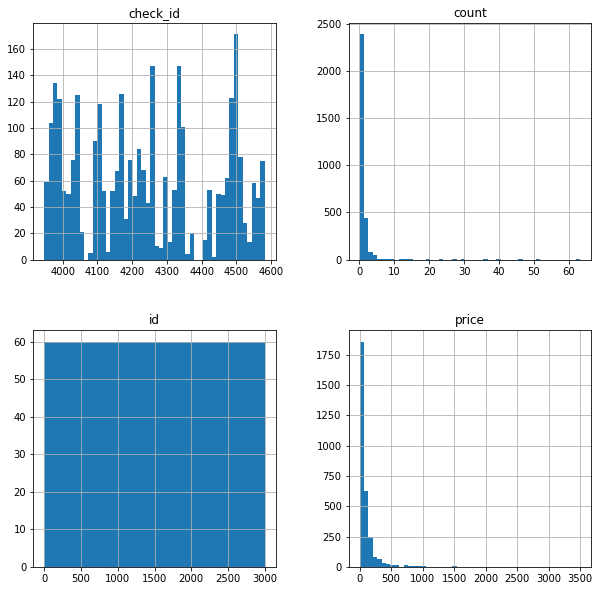

In [23]:
test.hist(figsize=(10, 10), bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000E617860>,
      dtype=object)

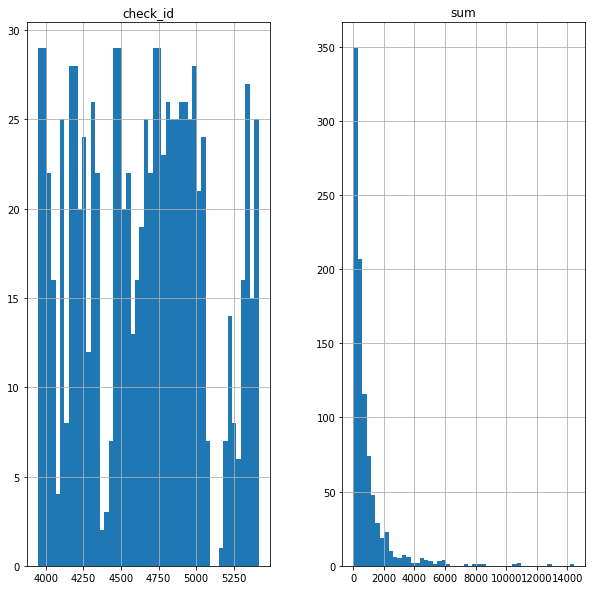

In [24]:
test_checks.hist(figsize=(10, 10), bins=50)

In [25]:
test.name.value_counts()[:20]

3300573 Пакет ПЯТЕРОЧКА 65х40см            13
Пакет ЛЕНТА средний майка 12кг              8
СТОИМ.                                      8
ХЛЕБ ЕВРОПЕЙСКИЙ800Г                        7
Пакет ЛЕНТА майка 9кг                       7
197 Лук репчатый 1кг                        7
Апельсины импорт вес. 1кг                   6
КЕФИР 2.5% 900 ГР                           6
БЕЗ НАИМЕНОВАНИЯ                            6
ЛУК РЕПЧАТЫЙ ВЕС                            5
АКВА ИДЕАЛ ПИТ 5Л                           5
СУШКА КУКУРУЗНАЯ 200                        5
КОНФ ГЛЕЙС 1КГ                              5
3230933 ТЕНД.Сахар-песок/Сахар бел.1кг      5
3074383 Картофель 1кг                       5
ЧИЗБУРГЕР                                   4
3182853 Яйца кур.С0 стол.фас.10шт           4
*71029 Зелень Укроп в упаковке 100г         4
2138999 Морковь весовая             1кг     4
Шоколад ALPEN GOLD Мол. каппучино 90г       4
Name: name, dtype: int64

In [26]:
train.columns

Index(['check_id', 'name', 'category', 'price', 'count'], dtype='object')

In [27]:
catalog1.head()

,category,description,precise_category
0,Рыба,"КРЕВЕТКА ВАРЕНАЯ ОЧИЩЕННАЯ CPUD ""АКУЛА"" 500 ГР.",Креветки замороженные
1,Чай и сладкое,ТОРТ ВАФЕЛЬНЫЙ ШОКОЛАДНИЦА ТМ КОЛОМЕНСКОЕ,Торты вафельные в шоколадной глазури длительно...
2,Для дома,"СРЕДСТВО ЖИДКОЕ МОЮЩЕЕ ДЛЯ МЫТЬЯ ПОСУДЫ ""SANIT...",Жидкость для мытья посуды
3,Табачные изделия,"СИГАРЕТЫ ""СТЮАРДЕССА"" 20 ШТ.",Сигареты классические другие
4,Бакалея,"ЛАПША БЫСТРОГО ПРИГОТОВЛЕНИЯ ""ДОШИРАК"" СО ВКУС...",Лапша быстрого приготовления другая


In [28]:
sorted(catalog1.category.unique())

['No',
 'Аксессуары',
 'Алкоголь',
 'Бакалея',
 'Гастрономия',
 'Дети',
 'Диетическое питание',
 'Для дома',
 'Животные',
 'Здоровье',
 'Косметика',
 'Кулинария',
 'Молочка',
 'Морозилка',
 'Мясо и птица',
 'Напитки',
 'Овощи и фрукты',
 'Рыба',
 'Табачные изделия',
 'Хлеб',
 'Чай и сладкое']

In [29]:
catalog2.head()

,category,description,main_category
0,Для дома,Lil1280-3\tблюдо,"Посуда, кухонные аксессуары"
1,Для дома,Lil1280-7\tблюдо,"Посуда, кухонные аксессуары"
2,Для дома,Lil1280-2\tблюдо,"Посуда, кухонные аксессуары"
3,Для дома,Lil1280-10\tблюдо,"Посуда, кухонные аксессуары"
4,Для дома,Lil1280-1\tблюдо,"Посуда, кухонные аксессуары"


In [30]:
catalog3.head()

,description,category_id,category_raw,PATH,category
0,"Пиво ""Жигулевское"" 0,5 л. св.",35,"Пиво, слабоалкогольные напитки","Алкоголь->Пиво, слабоалкогольные напитки",Алкоголь
1,пиво ягерь,35,"Пиво, слабоалкогольные напитки","Алкоголь->Пиво, слабоалкогольные напитки",Алкоголь
2,"Пиво светлое (пастеризованное) ""Жатецкий Гусь""...",35,"Пиво, слабоалкогольные напитки","Алкоголь->Пиво, слабоалкогольные напитки",Алкоголь
3,"Пиво ""Жатецкий Гусь "" светлое стекло 0,5 л., ...",35,"Пиво, слабоалкогольные напитки","Алкоголь->Пиво, слабоалкогольные напитки",Алкоголь
4,Линза полимерная астигматическая,35,"Пиво, слабоалкогольные напитки","Алкоголь->Пиво, слабоалкогольные напитки",Алкоголь


In [31]:
sorted(catalog2.category.unique())

['Алкоголь',
 'Бакалея',
 'Дети',
 'Диетическое питание',
 'Для дома',
 'Животные',
 'Здоровье',
 'Косметика',
 'Кулинария',
 'Молочка',
 'Морозилка',
 'Мясо и птица',
 'Напитки',
 'Овощи и фрукты',
 'Одежда и обувь',
 'Рыба',
 'Табачные изделия',
 'Хлеб',
 'Чай и сладкое']

In [32]:
catalog3.category.value_counts(dropna=False)

Не используется    21804
NaN                18135
Алкоголь           11920
Для дома            7159
Одежда и обувь      3548
Дети                2999
Здоровье             606
Упаковка             604
Машина               603
Компьютер            572
Name: category, dtype: int64

In [33]:
catalog1.precise_category.value_counts()[:20], catalog1.precise_category.nunique()

(Товары, ожидающие каталогизации                                 1379
 Товары, снятые с производства                                    522
 Семечки подсолнечника жареные несоленые                          217
 Пиво светлое в стекле 0,5л                                       192
 Крем-краска для волос                                            178
 Печенье другое                                                   166
 Водка классическая 0,5л                                          156
 Сигареты классические другие                                     147
 Каши фруктовые быстрого приготовления в порционных пакетиках     137
 Палочки кукурузные                                               135
 Масла эфирные                                                    132
 Средства от насекомых и грызунов, инсектициды                    131
 Бальзам для волос                                                131
 Кофе молотый традиционный другой                                 128
 Чипсы картофельные 

In [34]:
catalog2.main_category.value_counts()[:20], catalog2.main_category.nunique()

(Посуда, кухонные аксессуары            12720
 Ухаживающая косметика и аксессуары      7493
 Товары для офиса, канцтовары            6922
 Алкоголь                                6381
 Молочные продукты                       6375
 Детская одежда                          5732
 Косметика декоративная и аксессуары     5162
 Домашний текстиль                       5159
 Мясо и мясная продукция                 4915
 Гигиенические изделия и средства        4883
 Хлебобулочные, кондитерские изделия     4705
 Одежда и обувь                          3948
 Медицина                                3774
 Книги, журналы, газеты                  3674
 Табачные изделия                        3456
 Чай, кофе, какао                        3344
 Бытовая химия                           3176
 Снеки (семечки, сухарики, чипсы)        2964
 Товары для уборки помещений             2471
 Строительство и ремонт                  2466
 Name: main_category, dtype: int64, 66)

In [35]:
catalog3.category_raw.value_counts()[:20], catalog3.category_raw.nunique()

(Табачные изделия                   6045
 Продукты питания                   6014
 Хозтовары                          5975
 Косметика, гигиена и парфюмерия    5972
 Алкоголь                           5963
 Пиво, слабоалкогольные напитки     5957
 Цветы                              3050
 Детские товары, игрушки            2999
 Обувь                              2961
 Сувениры                            639
 Стройматериалы                      633
 н/д                                 626
 Зоотовары                           618
 Текстильные товары                  616
 Спорттовары                         613
 Канцтовары                          612
 Бытовые услуги                      608
 Игрушки для взрослых                607
 Мед.товары                          606
 Упаковка                            604
 Name: category_raw, dtype: int64, 29)

In [572]:
train_merged = pd.merge(train, train_checks, on='check_id', how='left')
test_merged = pd.merge(test, test_checks, on='check_id', how='left')

In [573]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13682 entries, 0 to 13681
Data columns (total 8 columns):
check_id     13682 non-null int64
name         13681 non-null object
category     13682 non-null object
price        13682 non-null float64
count        13682 non-null float64
shop_name    13453 non-null object
datetime     13682 non-null datetime64[ns]
sum          13682 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 962.0+ KB


In [574]:
train_merged.shop_name.fillna('', inplace=True)
test_merged.shop_name.fillna('', inplace=True)

In [575]:
train_merged.name.fillna('', inplace=True)

In [576]:
train_merged['name'] = train_merged['name'].apply(lambda s: ''.join([ch for ch in s if not ch.isdigit()]))

In [577]:
test_merged['name'] = test_merged['name'].apply(lambda s: ''.join([ch for ch in s if not ch.isdigit()]))

In [578]:
wrong_chars = '/.*#@$^&(){}[]+-_!~`=:"%,'

def delete_wrond_chars(s):
    for ch in wrong_chars:
        if ch in s:
            s = s.replace(ch, ' ')
    return s

train_merged['name'] = train_merged['name'].apply(delete_wrond_chars)
test_merged['name'] = test_merged['name'].apply(delete_wrond_chars)

In [579]:

train_merged['shop_name'] = train_merged['shop_name'].apply(delete_wrond_chars)
test_merged['shop_name'] = test_merged['shop_name'].apply(delete_wrond_chars)

In [537]:
train_merged.shop_name.unique()

array(['Не известно', 'ЕВРОПА', 'ПродвижениеФарм', 'ИП Роздухов М  Е ',
       'ОРЕОЛ', 'Агроторг', 'Тандер', '', 'Новый Книжный М', 'АШАН',
       'ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ОСТИН', 'Андора',
       'Газпромнефть Центр', 'Табер Трейд',
       'ЭЛЕКТРОСТАЛЬСКИЙ ЦЕНТР УСЛУГ', 'МЕРИДИАНА', 'ТД Перекресток',
       'ДЕТСКИЙ МИР', 'О Глория Джинс', 'Лента', 'РН Москва', 'О КЕЙ',
       'ОГУП <ЛИПЕЦKФАРМАЦИЯ>', '<ЛАСЕРТА №5>',
       'Объединенные Системы Сбора Платы', 'Эркафарм Северо запад',
       'ТОРГОВЫЙ ДОМ', 'Котон Текстиль', 'АКТИВ', 'СПАР МИДДЛ ВОЛГА',
       'ТД Интерторг', 'Дикси ЮГ', 'АГРОТОРГ', 'Бэст Прайс', 'ИКЕА ДОМ',
       'Теремок   Русские Блины', 'ИП Туркин И А ', 'Ирна',
       'З Москва Макдоналдс', 'Бургер Рус',
       'Элемент Трейд                            Сургут  Мира 15',
       'Касторама РУС', 'КЕА Груп', 'ИП Шухов Б А ', 'ГЭС розница',
       'ЛУКОЙЛ Северо Западнефтепродукт', 'Анжела', 'САKУРА',
       'Союз Св  Иоанна Воина', 'Т и К Продукты

In [580]:
tfidf = CountVectorizer(ngram_range=(2, 7), analyzer='char', max_features=50000) #TfidfVectorizer(ngram_range=(1, 3), max_features=50000)
full_df = pd.concat([train_merged, test_merged])

tfidf.fit(full_df.name + ' ' + full_df.shop_name)

train_name_tf = tfidf.transform(train_merged.name + ' ' + train_merged.shop_name)
test_name_tf = tfidf.transform(test_merged.name + ' ' + test_merged.shop_name)

In [581]:
cvect  = CountVectorizer(ngram_range=(1, 3), max_features=50000) #TfidfVectorizer(ngram_range=(1, 3), max_features=50000)
full_df = pd.concat([train_merged, test_merged])

cvect.fit(full_df.name + ' ' + full_df.shop_name)

train_name_cvect = cvect.transform(train_merged.name + ' ' + train_merged.shop_name)
test_name_cvect = cvect.transform(test_merged.name + ' ' + test_merged.shop_name)

In [582]:
train_merged['price'] = np.log(train_merged['price'] + 1)
train_merged['count'] = np.log(train_merged['count'] + 1)
train_merged['sum'] = np.log(train_merged['sum'] + 1)

test_merged['price'] = np.log(test_merged['price'] + 1)
test_merged['count'] = np.log(test_merged['count'] + 1)
test_merged['sum'] = np.log(test_merged['sum'] + 1)

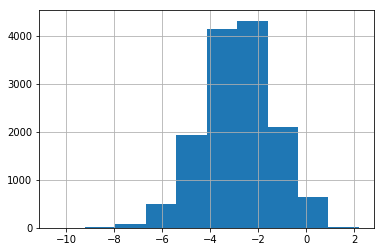

In [583]:
np.log((np.exp(train_merged['price']))/(np.exp(train_merged['sum']) )).hist()

In [480]:
def add_week_hour(df):
    dt = df['datetime'].dt
    
    df['weekday'] = dt.weekday
    df['is_weekend'] = dt.weekday.isin([5,6]).astype('int')
    df['hour'] = dt.hour

In [462]:
# add_time_features(train_merged)
# add_time_features(test_merged)

In [585]:
full_merged_mean = pd.concat([train_merged, test_merged])

check_count = dict(full_merged_mean.groupby('check_id')['check_id'].count())

shop_price_mean = dict(full_merged_mean.groupby('shop_name')['price'].mean())
shop_sum_mean = dict(full_merged_mean.groupby('shop_name')['sum'].mean())
train_merged['products_in_check'] = train_merged.check_id.apply(lambda ch: check_count[ch])
test_merged['products_in_check'] = test_merged.check_id.apply(lambda ch: check_count[ch])

train_merged['shop_price_mean'] = train_merged.shop_name.apply(lambda ch: shop_price_mean[ch])
test_merged['shop_price_mean'] = test_merged.shop_name.apply(lambda ch: shop_price_mean[ch])
train_merged['shop_sum_mean'] = train_merged.shop_name.apply(lambda ch: shop_sum_mean[ch])
test_merged['shop_sum_mean'] = test_merged.shop_name.apply(lambda ch: shop_sum_mean[ch])

In [586]:
cat_dummies = pd.get_dummies(train_merged, columns=['category'])
train_merged_mean = cat_dummies.copy()
test_merged_mean = test_merged.copy()

skf_mean = StratifiedKFold(5, shuffle=True, random_state=17)

for c in cat_dummies.columns[cat_dummies.columns.str.startswith('category_')]:
    train_merged_mean, test_merged_mean = mean_target_enc(train_merged_mean, train_merged_mean[c], test_merged_mean, ['shop_name', 'products_in_check'], skf_mean)

In [587]:
cat_ohe = ['category_Алкоголь', 'category_Бакалея', 'category_Гастрономия',
       'category_Дети', 'category_Для дома', 'category_Животные',
       'category_Здоровье', 'category_Кафе', 'category_Компьютер',
       'category_Косметика', 'category_Кулинария', 'category_Машина',
       'category_Молочка', 'category_Мясо и птица', 'category_Напитки',
       'category_Не определена', 'category_Овощи и фрукты',
       'category_Одежда и обувь', 'category_Рыба', 'category_Снеки',
       'category_Табак', 'category_Упаковка', 'category_Услуги',
       'category_Хлеб', 'category_Чай и сладкое']

train_merged_mean.drop(cat_ohe, axis=1, inplace=True)
# train_merged.drop(cat_ohe, axis=1, inplace=True)

In [588]:


train_merged, test_merged = train_merged_mean, test_merged_mean

In [589]:
train_merged['avg_price_in_check'] = np.log((np.exp(train_merged['price']))/(np.exp(train_merged['sum']) ))
test_merged['avg_price_in_check'] = np.log((np.exp(test_merged['price']))/(np.exp(test_merged['sum']) ))

In [ ]:
train_merged['catal_pred'] = train_pred_catal_cat
test_merged['catal_pred'] = test_pred_catal_cat

full_merged_mean = pd.concat([train_merged, test_merged])
full_merged_mean = pd.get_dummies(full_merged_mean, columns=['catal_pred'])

train_merged, test_merged = full_merged_mean[:train_merged.shape[0]], full_merged_mean[train_merged.shape[0]:]

In [590]:
lb = LabelEncoder()
mrgd_train = pd.merge(train, train_checks, on='check_id', how='left')
y = lb.fit_transform(mrgd_train.category)
check_id = train_merged.check_id

train_df = train_merged.drop(['name', 'shop_name', 'datetime', 'check_id'], axis=1)
test_df = test_merged.drop(['name', 'shop_name', 'datetime', 'check_id', 'id'], axis=1)

train_prep = hstack([train_df, train_name_tf, train_name_cvect])
test_prep = hstack([test_df, test_name_tf, test_name_cvect])

In [593]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold

# gkf = list(GroupKFold(n_splits=5).split(train_prep, y, check_id.values))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
score = cross_val_score(LogisticRegression(C=10), train_prep, y, scoring='neg_log_loss', cv = skf, n_jobs = -1)
print(score)
"%.3f +- %.4f" % (-np.mean(score), np.std(score))

[-0.38409205 -0.34856672 -0.36979933 -0.41101319 -0.37756278]


'0.378 +- 0.0203'

In [594]:
model = LogisticRegression(C=10)
model.fit(train_prep, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [595]:
p_test = model.predict_proba(test_prep)
test = test_merged[['id']]

In [597]:
for i, c in enumerate(lb.classes_):
    test[c] = list(map(lambda x: '%.4f' % x, p_test[:, i]))

In [598]:
test['id'] = test['id'].astype('int')

In [599]:
test.to_csv('checks_cv_sh_name_char2_7_cv1_3_50k_ch_sh_targ_means_checksize_log_ft.csv.gz', compression='gzip', index = False)

In [257]:
len(set(test.check_id.unique()).intersection( test_checks.check_id.unique()))

418

In [258]:
test.check_id.nunique()

418

In [259]:
len(set(train.check_id.unique()).intersection( train_checks.check_id.unique())), train.check_id.nunique()

(2041, 2041)

In [300]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13682 entries, 0 to 13681
Data columns (total 15 columns):
check_id      13682 non-null int64
name          13681 non-null object
price         13682 non-null float64
count         13682 non-null float64
shop_name     13453 non-null object
datetime      13682 non-null datetime64[ns]
check_sum     13682 non-null float64
year          13682 non-null int64
month         13682 non-null int64
dayOfMonth    13682 non-null int64
dayOfYear     13682 non-null int64
weekday       13682 non-null int64
is_weekend    13682 non-null int32
hour          13682 non-null int64
catal_cat     13682 non-null int64
dtypes: datetime64[ns](1), float64(3), int32(1), int64(8), object(2)
memory usage: 1.6+ MB


In [261]:
train_merged.rename(columns={'sum': 'check_sum'}, inplace=True)
test_merged.rename(columns={'sum': 'check_sum'}, inplace=True)

In [262]:
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 8 columns):
id           3000 non-null int64
check_id     3000 non-null int64
name         3000 non-null object
price        3000 non-null float64
count        3000 non-null float64
shop_name    2952 non-null object
datetime     3000 non-null datetime64[ns]
check_sum    3000 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 210.9+ KB


In [263]:
def add_time_features(df):
    dt = df['datetime'].dt
    
    df['year'] = dt.year
    df['month'] = dt.month
    df['dayOfMonth']= dt.day
    df['dayOfYear'] = dt.dayofyear
    df['weekday'] = dt.weekday
    df['is_weekend'] = dt.weekday.isin([5,6]).astype('int')
    df['hour'] = dt.hour

In [264]:
add_time_features(train_merged)
add_time_features(test_merged)

In [265]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13682 entries, 0 to 13681
Data columns (total 15 columns):
check_id      13682 non-null int64
name          13681 non-null object
category      13682 non-null object
price         13682 non-null float64
count         13682 non-null float64
shop_name     13453 non-null object
datetime      13682 non-null datetime64[ns]
check_sum     13682 non-null float64
year          13682 non-null int64
month         13682 non-null int64
dayOfMonth    13682 non-null int64
dayOfYear     13682 non-null int64
weekday       13682 non-null int64
is_weekend    13682 non-null int32
hour          13682 non-null int64
dtypes: datetime64[ns](1), float64(3), int32(1), int64(7), object(3)
memory usage: 1.6+ MB


In [160]:
lb = LabelEncoder()
train_merged['cat_lbl'] = lb.fit_transform(train_merged['category'])

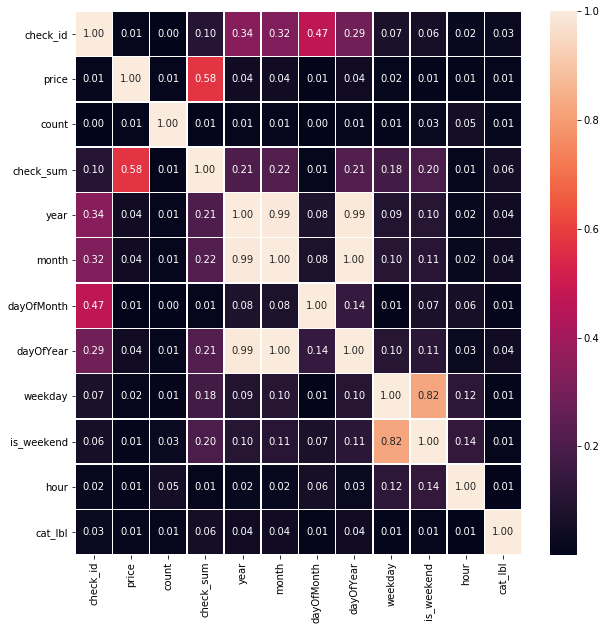

In [48]:
cm = train_merged.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(np.abs(cm), annot=True, fmt=".2f", linewidths=.5)

In [49]:
pca = PCA(n_components=0.9)
tr_m_pca = pca.fit_transform(train_merged.drop('cat_lbl', axis=1).select_dtypes(include=['float64', 'int64', 'int32']))

In [50]:
pca.components_.shape

(2, 11)

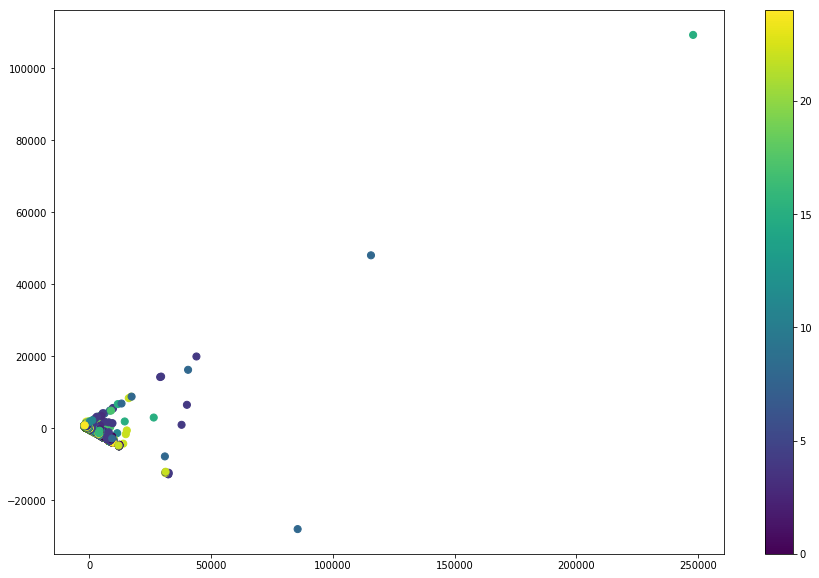

In [51]:

plt.figure(figsize=(15, 10))
plt.scatter(tr_m_pca[:, 0], tr_m_pca[:, 1], c=train_merged.cat_lbl, s=50, cmap='viridis')
plt.colorbar()

In [266]:
test_merged.columns

Index(['id', 'check_id', 'name', 'price', 'count', 'shop_name', 'datetime',
       'check_sum', 'year', 'month', 'dayOfMonth', 'dayOfYear', 'weekday',
       'is_weekend', 'hour'],
      dtype='object')

In [87]:
catalog_m = pd.merge(catalog2, train, left_on='description', right_on='name')

In [113]:
catalog_clmns = ['description', 'category']

full_catalog = pd.concat([catalog1[catalog_clmns],catalog2[catalog_clmns], catalog3[catalog_clmns]], ignore_index=True)

In [109]:
full_catalog.shape

(262835, 2)

In [119]:
diff = set(train.category.unique()).symmetric_difference(full_catalog.category.unique())

In [120]:
diff.intersection(train.category.unique()), diff.intersection(full_catalog.category.unique())

({'Не определена', 'Снеки', 'Табак', 'Услуги'},
 {'No', 'Аксессуары', 'Диетическое питание', 'Морозилка', 'Табачные изделия'})

In [101]:
train.category.unique()

array(['Чай и сладкое', 'Для дома', 'Упаковка', 'Молочка', 'Бакалея',
       'Дети', 'Овощи и фрукты', 'Напитки', 'Здоровье', 'Косметика',
       'Гастрономия', 'Кафе', 'Мясо и птица', 'Хлеб', 'Услуги',
       'Одежда и обувь', 'Рыба', 'Машина', 'Не определена', 'Животные',
       'Кулинария', 'Алкоголь', 'Снеки', 'Табак', 'Компьютер'],
      dtype=object)

In [114]:

cafe = pd.read_csv(os.path.join(data_dir, 'cafe.csv'), sep=',')
cafe['category'] = 'Кафе'
cafe['description'] = cafe['name']
full_catalog = pd.concat([full_catalog, cafe[['description', 'category']]], ignore_index=True)

In [117]:
full_catalog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374039 entries, 0 to 413978
Data columns (total 2 columns):
description    374039 non-null object
category       374039 non-null object
dtypes: object(2)
memory usage: 8.6+ MB


In [116]:
full_catalog.dropna(inplace=True)
full_catalog = full_catalog[full_catalog.category != 'Не используется']

In [118]:
full_catalog.category.value_counts()

Кафе                   151143
Для дома                65680
Бакалея                 24550
Алкоголь                20845
Косметика               17197
Одежда и обувь          13651
Чай и сладкое           11596
Молочка                 11254
Дети                    10658
Здоровье                 7030
Гастрономия              5835
Хлеб                     5606
Мясо и птица             5527
Морозилка                3802
Табачные изделия         3789
Напитки                  3600
Овощи и фрукты           2648
Рыба                     2056
No                       1901
Животные                 1753
Кулинария                1187
Диетическое питание       951
Упаковка                  604
Машина                    603
Компьютер                 572
Аксессуары                  1
Name: category, dtype: int64

In [600]:
full_catalog['description'] = full_catalog['description'].apply(lambda s: ''.join([ch for ch in s if not ch.isdigit()]))
full_catalog['description'] = full_catalog['description'].apply(delete_wrond_chars)

In [ ]:

# tfidf_sites = tfidf.fit(all_strings)

from sklearn.feature_extraction.text import CountVectorizer

trans_cat_char = CountVectorizer(ngram_range=(2, 7), analyzer='char', max_features=30000)
trans_cat = CountVectorizer(ngram_range=(1, 3), max_features=30000)
# trans_cat = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)

catal_cv = trans_cat.fit_transform(full_catalog.description)
catal_cv_char = trans_cat_char.fit_transform(full_catalog.description)

catal_trans = hstack([catal_cv, catal_cv_char])

In [602]:
cat_lb = LabelEncoder()

full_catalog['catalog_lbl'] = cat_lb.fit_transform(full_catalog.category)

In [128]:
np.unique(catalog_lbl)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=int64)

In [ ]:

skf = StratifiedKFold(5, shuffle=True, random_state=42)
score = cross_val_score(LogisticRegression(), catal_trans, full_catalog['catalog_lbl'], cv = skf, n_jobs = -1)
print(score)
"%.3f +- %.4f" % (-np.mean(score), np.std(score))


In [143]:
catalog_lr = LogisticRegression(class_weight='balanced')
catalog_lr.fit(catal_tfidf, full_catalog['catalog_lbl'])

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [267]:
train_m_name = trans_cat.transform(train_merged.name.fillna(''))
test_m_name = trans_cat.transform(test_merged.name)

In [268]:
train_pred_catal_cat = catalog_lr.predict(train_m_name)
test_pred_catal_cat = catalog_lr.predict(test_m_name)

In [269]:
train_merged['catal_cat'] = train_pred_catal_cat
test_merged['catal_cat'] = test_pred_catal_cat

In [270]:
def mean_target_enc(train_df, y_train, valid_df, cat_features, skf):
    import warnings
    warnings.filterwarnings('ignore')
    target_name = y_train.name
    
    glob_mean = y_train.mean()
    train_df = pd.concat([train_df, pd.Series(y_train, name='y')], axis=1)
    new_train_df = train_df.copy()  

    for col in cat_features:
        new_train_df[col + '_mean_' + target_name] = [glob_mean for _ in range(new_train_df.shape[0])]

    for train_idx, valid_idx in skf.split(train_df, y_train):
        train_df_cv, valid_df_cv = train_df.iloc[train_idx, :], train_df.iloc[valid_idx, :]

        for col in cat_features:
            
            means = valid_df_cv[col].map(train_df_cv.groupby(col)['y'].mean())
            valid_df_cv[col + '_mean_' + target_name] = means.fillna(glob_mean)
            
        new_train_df.iloc[valid_idx] = valid_df_cv
    
    new_train_df.drop(['y'], axis=1, inplace=True)
    
    for col in cat_features:
        means = valid_df[col].map(train_df.groupby(col)['y'].mean())
        valid_df[col + '_mean_' + target_name] = means.fillna(glob_mean)
        
#     valid_df.drop(cat_features, axis=1, inplace=True)
    
    return new_train_df, valid_df

In [271]:
train_merged = pd.get_dummies(train_merged, columns=['category'])

In [272]:
skf = StratifiedKFold(5, shuffle=True, random_state=17)

In [273]:
train_merged_mean = train_merged.copy()
test_merged_mean = test_merged.copy()

for c in train_merged.columns[train_merged.columns.str.startswith('category_')]:
    train_merged_mean, test_merged_mean = mean_target_enc(train_merged_mean, train_merged_mean[c], test_merged_mean, ['shop_name', 'dayOfMonth', 'weekday', 'hour', 'is_weekend'], skf)

In [274]:
cat_ohe = ['category_Алкоголь', 'category_Бакалея', 'category_Гастрономия',
       'category_Дети', 'category_Для дома', 'category_Животные',
       'category_Здоровье', 'category_Кафе', 'category_Компьютер',
       'category_Косметика', 'category_Кулинария', 'category_Машина',
       'category_Молочка', 'category_Мясо и птица', 'category_Напитки',
       'category_Не определена', 'category_Овощи и фрукты',
       'category_Одежда и обувь', 'category_Рыба', 'category_Снеки',
       'category_Табак', 'category_Упаковка', 'category_Услуги',
       'category_Хлеб', 'category_Чай и сладкое']

train_merged_mean.drop(cat_ohe, axis=1, inplace=True)
train_merged.drop(cat_ohe, axis=1, inplace=True)

In [275]:
full_merged = pd.concat([train_merged_mean, test_merged_mean])

check_count = dict(full_merged.groupby('check_id')['check_id'].count())
product_price_mean_ch = dict(full_merged.groupby('check_id')['price'].mean())
product_price_mean_shop = dict(full_merged.groupby('shop_name')['price'].mean())
check_sum_mean_shop = dict(full_merged.groupby('shop_name')['check_sum'].mean())

In [276]:
train_merged_mean['products_in_check'] = train_merged_mean.check_id.apply(lambda ch: check_count[ch])
test_merged_mean['products_in_check'] = test_merged_mean.check_id.apply(lambda ch: check_count[ch])

train_merged_mean['product_price_mean_ch'] = train_merged_mean.check_id.apply(lambda ch: product_price_mean_ch[ch])
test_merged_mean['products_in_check'] = test_merged_mean.check_id.apply(lambda ch: product_price_mean_ch[ch])

train_merged_mean['product_price_mean_shop'] = train_merged_mean.shop_name.apply(lambda ch: 0 if pd.isnull(ch) else product_price_mean_shop[ch])
test_merged_mean['product_price_mean_shop'] = test_merged_mean.shop_name.apply(lambda ch: 0 if pd.isnull(ch) else product_price_mean_shop[ch])

train_merged_mean['check_sum_mean_shop'] = train_merged_mean.shop_name.apply(lambda ch: 0 if pd.isnull(ch) else check_sum_mean_shop[ch])
test_merged_mean['check_sum_mean_shop'] = test_merged_mean.shop_name.apply(lambda ch: 0 if pd.isnull(ch) else check_sum_mean_shop[ch])



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000341E8438>,
      dtype=object)

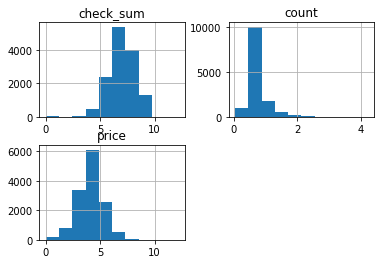

In [277]:
np.log(train_merged_mean[['count', 'price', 'check_sum']] + 1).hist()

In [278]:
from scipy.stats import shapiro, skewtest, skew

log_df = np.log(train_merged_mean[['count', 'price', 'check_sum']] + 1)

print('Normality count: {}'.format(shapiro(log_df['count'])))
print('Normality price: {}'.format(shapiro(log_df['price'])))
print('Normality check sum: {}'.format(shapiro(log_df['check_sum'])))

Normality count: (0.6213515996932983, 0.0)
Normality price: (0.9813460111618042, 1.1262228751286233e-38)
Normality check sum: (0.9827343821525574, 1.6727216811776253e-37)


((array([-3.88740906, -3.66645413, -3.54533757, ...,  3.54533757,
          3.66645413,  3.88740906]),
  array([ 0.        ,  0.        ,  0.        , ..., 11.43161779,
         11.43161779, 12.16941385])),
 (1.2169895968397368, 6.9624787291876284, 0.9912736749136692))

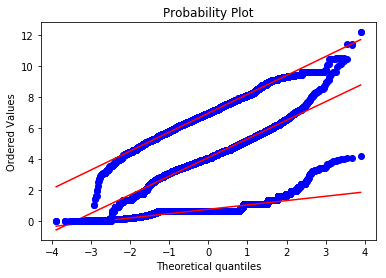

In [279]:

import scipy.stats as stats

stats.probplot(list(log_df['count']), dist="norm", plot=plt)

stats.probplot(list(log_df['price']), dist="norm", plot=plt)

stats.probplot(list(log_df['check_sum']), dist="norm", plot=plt)

In [325]:
train_merged_mean['count'] = np.log(train_merged['count'] + 1)
train_merged_mean['price'] = np.log(train_merged['price'] + 1)
train_merged_mean['check_sum'] = np.log(train_merged['sum'] + 1)

In [378]:
test_merged_mean['count'] = np.log(test_merged_mean['count'] + 1)
test_merged_mean['price'] = np.log(test_merged_mean['price'] + 1)
test_merged_mean['check_sum'] = np.log(test_merged_mean['check_sum'] + 1)

In [338]:

strings = train_merged.name.fillna('').str.lower().replace('.', ' ')
strings_test = test_merged.name.fillna('').str.lower().replace('.', ' ')
all_strings = pd.concat([strings, strings_test])

In [384]:

# tfidf_sites = tfidf.fit(all_strings)

from sklearn.feature_extraction.text import CountVectorizer

# trans = CountVectorizer(analyzer='char', ngram_range=(3, 7), max_features=50000)
trans = TfidfVectorizer(analyzer='char', ngram_range=(3, 7), max_features=50000)

vect_fit = trans.fit(all_strings)

In [283]:
idx = list([vect_fit.transform(train_merged.name[:1]).toarray().nonzero()[1]])
idx

[array([ 8670,  8671,  8672, 32684, 32771, 34621, 34650, 34651, 47119,
        47168, 47169, 47853, 47854, 47855, 48322, 48356, 48357, 81014,
        81015, 81016, 90527], dtype=int64)]

In [284]:
len(vect_fit.vocabulary_)

92815

In [385]:

train_tfidf = vect_fit.transform(strings)
test_tfidf = vect_fit.transform(strings_test)

In [370]:
np.isinf(train_merged_mean).sum().mean()

0.0

In [ ]:
train_merged_mean.describe()

In [289]:
full_merged_mean = pd.concat([train_merged_mean, test_merged_mean])
full_merged_dumm = pd.get_dummies(full_merged_mean, columns=['dayOfMonth', 'month', 'hour', 'weekday', 'shop_name', 'year', 'catal_cat'])

train_merged_mean, test_merged_mean = full_merged_dumm[:train_merged_mean.shape[0]], full_merged_dumm[train_merged_mean.shape[0]:]

In [303]:
y = lb.fit_transform(train_merged['category'])

In [304]:

train_merged_mean.drop(['check_id', 'name', 'datetime', 'dayOfYear'], axis=1, inplace=True)
test_merged_mean.drop(['check_id', 'name', 'datetime', 'dayOfYear'], axis=1, inplace=True)

In [309]:

train_merged_mean.drop(['id'], axis=1, inplace=True)
test_merged_mean.drop(['id'], axis=1, inplace=True)

In [379]:
test_merged_mean['product_price_mean_ch'].fillna(0, inplace=True)

In [380]:

st = StandardScaler()
train_merged_mean_st = st.fit_transform(train_merged_mean)
test_merged_mean_st = st.transform(test_merged_mean)

In [372]:

from scipy.sparse import csr_matrix, hstack

In [386]:
train_prep = hstack([train_merged_mean_st, train_tfidf])
test_prep = hstack([test_merged_mean_st, test_tfidf])

In [387]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold

gkf = list(GroupKFold(n_splits=4).split(train_prep, y, train_merged.check_id.values))
score = cross_val_score(LogisticRegression(), train_prep, y, scoring='neg_log_loss', cv = gkf, n_jobs = -1)
print(score)
"%.3f +- %.4f" % (-np.mean(score), np.std(score))

[-1.45405999 -1.40332155 -1.34715087 -1.45113862]


'1.414 +- 0.0435'

In [75]:
import xgboost as xgb
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.metrics import log_loss

In [76]:
X_train, X_val, y_train, y_val = train_test_split(train_prep, y, test_size=0.3, random_state=17)

In [77]:
def score(params):
    print("Training with params:")
    print(params)
    params['max_depth'] = int(params['max_depth'])
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    model = xgb.train(params, dtrain, params['num_round'])
    predictions = model.predict(dvalid).reshape((X_val.shape[0], 25))
    score = log_loss(y_val, predictions)
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

def optimize(trials):
    space = {
             'num_round': 500,
             'learning_rate': hp.quniform('eta', 0.005, 0.05, 0.005),
             'max_depth': hp.quniform('max_depth', 3, 14, 1),
             'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma': hp.quniform('gamma', 0.5, 1, 0.01),
             'colsample_bytree': hp.quniform('colsample_bytree', 0.4, 1, 0.05),
             'num_class' : 25,
             'eval_metric': 'logloss',
             'objective': 'multi:softprob',
             'nthread' : 8,
             'silent' : 1
             }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=10)
    return best

In [78]:
trials = Trials()
best_params = optimize(trials)
best_params

Training with params:
{'colsample_bytree': 0.45, 'eval_metric': 'logloss', 'gamma': 0.98, 'learning_rate': 0.045, 'max_depth': 6.0, 'min_child_weight': 7.0, 'nthread': 8, 'num_class': 25, 'num_round': 500, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.55}
	Score 1.0938503702078128


Training with params:
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'logloss', 'gamma': 0.78, 'learning_rate': 0.02, 'max_depth': 13.0, 'min_child_weight': 5.0, 'nthread': 8, 'num_class': 25, 'num_round': 500, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.55}
	Score 0.9890745367541746


Training with params:
{'colsample_bytree': 0.8500000000000001, 'eval_metric': 'logloss', 'gamma': 0.55, 'learning_rate': 0.005, 'max_depth': 9.0, 'min_child_weight': 3.0, 'nthread': 8, 'num_class': 25, 'num_round': 500, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.8500000000000001}
	Score 1.2059947320118312


Training with params:
{'colsample_bytree': 0.6000000000000001, 'eva

KeyboardInterrupt: 

In [82]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val)

params = {
    'objective':'multi:softprob',
    'max_depth':1,
    'silent':1,
    'nthread': 8,
    'eval_metric': 'logloss',
    'num_class' : 25,
#     'booster': 'dart',
#     'eta':0.05,
#     'gamma': 0.5,
#     'lambda': 100,
#     'alpha': 0.05
}

num_rounds = 500
xgb_ = xgb.train(params, dtrain, num_rounds)

xgb__pred = xgb_.predict(dval).reshape((X_val.shape[0], params['num_class']))
print(xgb__pred[:3])

log_loss(y_val, xgb__pred)

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan]]


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
trans_cat.transform()